# Your First Image Classifier: Using MLP to Classify Images
# Test

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda.
Containing only 3,000 images, the Animals dataset is meant to be another **introductory** dataset
that we can quickly train a Multilayer Perceptron (MLP) model and obtain results that can be compared with KNN model trained earlier.
Let's take the following steps:

1. Download the encoder and model artifacts
2. Evaluate the model using the test dataset
3. Create an interactive table

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [14]:
!pip install wandb -qU

In [15]:
import wandb
wandb.login()

True

### Import Packages

In [16]:
# load packpages
import logging
import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os
import re
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

In [17]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Test evaluation

In [18]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "mlp_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model:latest",
  "deploy": "inference_result"
}

In [19]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",project=args["project_name"], job_type="Test")

logger.info("Downloading the test data")
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

15-10-2022 12:38:19 Downloading the test data


In [20]:
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

15-10-2022 12:38:19 Test x: (750, 3072)
15-10-2022 12:38:20 Test y: (750,)


### Download the inference model and encoder object

In [21]:
logger.info("Downloading the encoder and inference model")
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

15-10-2022 12:38:20 Downloading the encoder and inference model


### Unpacking the artifacts

In [22]:
# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = joblib.load(model_path)

In [23]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

In [24]:
# encode the labels as integers
test_y = encoder.transform(test_y)

# train a k-NN classifier on the raw pixel intensities
logger.info("[INFO] evaluating MLP classifier...")
predict = model.predict(test_x)

15-10-2022 12:38:21 [INFO] evaluating MLP classifier...


## Step 03: Evaluating the network

In [25]:
# make predictions
print("[INFO] make predictions using test set...")
predictions = model.predict(test_x)

[INFO] make predictions using test set...


In [26]:
print(classification_report(test_y, predict,target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.54      0.49      0.51       262
        dogs       0.41      0.13      0.20       249
       panda       0.50      0.91      0.65       239

    accuracy                           0.51       750
   macro avg       0.49      0.51      0.45       750
weighted avg       0.49      0.51      0.45       750



In [27]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y, predict, beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y, predict, zero_division=1,average='weighted')
recall = recall_score(test_y, predict, zero_division=1,average='weighted')
acc = accuracy_score(test_y, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

15-10-2022 12:38:21 Test Evaluation metrics
15-10-2022 12:38:21 Test Accuracy: 0.5053333333333333
15-10-2022 12:38:21 Test Precision: 0.4864865148793252
15-10-2022 12:38:21 Test Recall: 0.5053333333333333
15-10-2022 12:38:21 Test F1: 0.4526255540928458


In [28]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

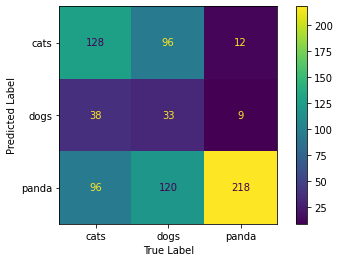

In [29]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,test_y),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [30]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_test": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

15-10-2022 12:38:21 Uploading figures


In [31]:
# create a folder named 'test'
dirname = 'test'
os.mkdir(dirname)

# re-generate test images and put all of them in test/ folder
for i in range(test_x.shape[0]):
  img = test_x[i].reshape(32,32,3)
  cv2.imwrite(os.path.join(dirname,''.join([str(i),'.jpg'])),img)

In [32]:
# sort image Paths by name
# 0.jpg, 1.jpg, 2.jpg, ....
imagePaths = list(paths.list_images("test"))
imagePaths = sorted(imagePaths, key=lambda x: int(re.search(r"(\d+)\.[a-z]+$", x).group(1)))

In [33]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["test id","image", "target","predict"])

# create a new artifact to store the EDA data
inference_result = wandb.Artifact(args["deploy"], type="INFERENCE")

In [34]:
# append all images to the artifact
for i,img in enumerate(imagePaths):
  image = cv2.imread(img)
  preview_dt.add_data(i, 
                      wandb.Image(img), 
                      encoder.inverse_transform([test_y[i]])[0], 
                      encoder.inverse_transform([predict[i]])[0])

In [35]:
# save artifact to W&B
inference_result.add(preview_dt, "Inference_Table")
run.log_artifact(inference_result)

In [36]:
run.finish()

Acc,0.50533
F1,0.45263
Precision,0.48649
Recall,0.50533
